# VAE Comparison: PyTorch vs TensorRT
Simple notebook to compare reconstruction quality.

In [1]:
import torch
import tensorrt as trt
import numpy as np
from PIL import Image
from diffusers import AutoModel, AutoencoderKL
from torchvision import transforms
import os
from jupyter_compare_view import compare
from IPython.display import display

# --- CONFIG ---
IMAGE_PATH = r"C:\programming\auto_remaster\inference_optimization\170_2x.png"
MODEL_ID = "fal/FLUX.2-Tiny-AutoEncoder"
ENC_PATH = "flux_vae_tiny_trt/vae_encoder.plan"
DEC_PATH = "flux_vae_tiny_trt/vae_decoder.plan"
SIZE = 512
USE_FP16 = True

device = "cuda"
dtype = torch.float16 if USE_FP16 else torch.float32

c:\programming\auto_remaster\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Jupyter compare_view v0.2.4


In [2]:
# --- LOAD MODEL & ENGINES ---
print("Loading Torch Model...")
try:
    vae = AutoModel.from_pretrained(MODEL_ID, trust_remote_code=True).to(device, dtype=dtype)
except:
    vae = AutoencoderKL.from_pretrained(MODEL_ID).to(device, dtype=dtype)
vae.eval()

print("Loading TRT Engines...")
logger = trt.Logger(trt.Logger.WARNING)

def load_engine(path):
    with open(path, "rb") as f, trt.Runtime(logger) as runtime:
        # Deserialize the engine from the .plan file
        return runtime.deserialize_cuda_engine(f.read())

enc_engine = load_engine(ENC_PATH)
dec_engine = load_engine(DEC_PATH)

# Execution Context stores intermediate state for inference
enc_ctx = enc_engine.create_execution_context()
dec_ctx = dec_engine.create_execution_context()

Loading Torch Model...


`trust_remote_code` is enabled. Downloading code from fal/FLUX.2-Tiny-AutoEncoder. Please ensure you trust the contents of this repository
The config attributes {'auto_map': {'AutoModel': 'flux2_tiny_autoencoder.Flux2TinyAutoEncoder'}} were passed to Flux2TinyAutoEncoder, but are not expected and will be ignored. Please verify your config.json configuration file.


Loading TRT Engines...


In [3]:
# --- UTILS ---
def process_image(path):
    img = Image.open(path).convert("RGB")
    t = transforms.Compose([
        transforms.Resize(SIZE, interpolation=transforms.InterpolationMode.LANCZOS),
        transforms.CenterCrop(SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    return t(img).unsqueeze(0).to(device, dtype=dtype)

def tensor_to_image(t):
    t = (t * 0.5 + 0.5).clamp(0, 1)
    if t.ndim == 3:
        t = t.unsqueeze(0)
    t = t.cpu().permute(0, 2, 3, 1).float().numpy()[0]
    return Image.fromarray((t * 255).astype(np.uint8))

inp_tensor = process_image(IMAGE_PATH)
print(f"Input shape: {inp_tensor.shape}")

Input shape: torch.Size([1, 3, 512, 512])


In [4]:
# --- TORCH INFERENCE ---
print("Running Torch...")
with torch.no_grad():
    encoded = vae.encode(inp_tensor)
    if hasattr(encoded, "latent_dist"): latents = encoded.latent_dist.sample()
    elif hasattr(encoded, "latents"): latents = encoded.latents
    else: latents = encoded[0]
    
    out_torch = vae.decode(latents, return_dict=False)[0]
    print("Torch inference done.")

Running Torch...
Torch inference done.


### TensorRT Inference Explained

**The Handover Magic:**
In PyTorch, we typically do `y = model(x)`. In TensorRT, we pre-allocate the memory for `y` and tell the engine "Put the result HERE".

To pass data from Encoder to Decoder:
1. We create a tensor called `lat_tensor`.
2. We tell the Encoder: "Write your output to `lat_tensor`".
3. We tell the Decoder: "Read your input from `lat_tensor`".

Since both engines point to the exact same GPU memory address (`lat_tensor.data_ptr()`), the data is instantly available to the Decoder as soon as the Encoder finishes writing it. No copying needed.

In [5]:
# --- TENSORRT INFERENCE ---
print("Running TensorRT...")
stream = torch.cuda.Stream()

# 1. Helper to find binding names (Input vs Output) in the engine
def get_binding_name(engine, mode): # mode 0: Input, 1: Output
    for i in range(engine.num_io_tensors):
        name = engine.get_tensor_name(i)
        if engine.get_tensor_mode(name) == mode:
            return name
    return None

# Resolve names for inputs and outputs
enc_in_name = get_binding_name(enc_engine, trt.TensorIOMode.INPUT)
enc_out_name = get_binding_name(enc_engine, trt.TensorIOMode.OUTPUT)
dec_in_name = get_binding_name(dec_engine, trt.TensorIOMode.INPUT)
dec_out_name = get_binding_name(dec_engine, trt.TensorIOMode.OUTPUT)

# 2. Tell TRT the input shape so it can compute output sizes
enc_ctx.set_input_shape(enc_in_name, inp_tensor.shape)

# Calculate dynamic output shape for Latents based on engine logic
lat_shape = list(enc_engine.get_tensor_shape(enc_out_name))
lat_shape = tuple([inp_tensor.shape[0]] + lat_shape[1:]) # Prepend batch dim

# === [KEY STEP] ===
# Allocate GPU buffer for Latents. 
# This tensor acts as the bridge between Encoder and Decoder.
lat_tensor = torch.zeros(lat_shape, device=device, dtype=dtype)
# ==================

# Prepare Decoder
dec_ctx.set_input_shape(dec_in_name, lat_shape)
out_shape = list(dec_engine.get_tensor_shape(dec_out_name))
if len(out_shape) == 3:
    out_shape = [inp_tensor.shape[0]] + out_shape
else:
    out_shape = [inp_tensor.shape[0]] + out_shape[1:]
    
# Allocate GPU buffer for Final Output
out_trt = torch.zeros(tuple(out_shape), device=device, dtype=dtype)

# 3. Set Tensor Addresses (Pointers)

enc_ctx.set_tensor_address(enc_in_name, inp_tensor.data_ptr())

# === [THE HANDOVER] ===
# We tell Encoder: "Write output to lat_tensor"
enc_ctx.set_tensor_address(enc_out_name, lat_tensor.data_ptr())

# We tell Decoder: "Read input from lat_tensor"
# Because they point to the SAME memory, no copy is needed!
dec_ctx.set_tensor_address(dec_in_name, lat_tensor.data_ptr())
# ======================

dec_ctx.set_tensor_address(dec_out_name, out_trt.data_ptr())

# 4. Execute Async
enc_ctx.execute_async_v3(stream_handle=stream.cuda_stream)
dec_ctx.execute_async_v3(stream_handle=stream.cuda_stream)

# Wait for GPU to finish
stream.synchronize()
print("TensorRT inference done.")

Running TensorRT...
TensorRT inference done.


Comparison 1: Left=Torch, Right=TensorRT



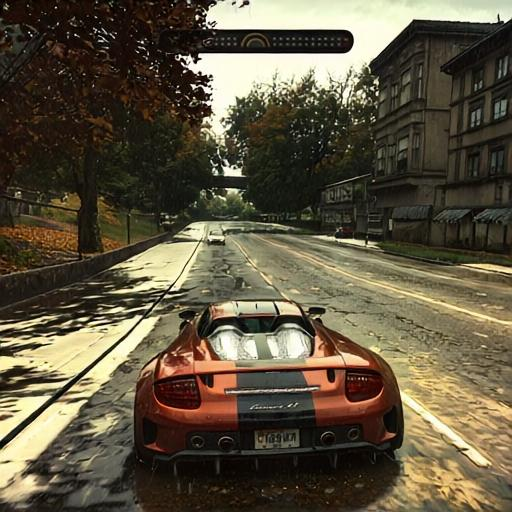
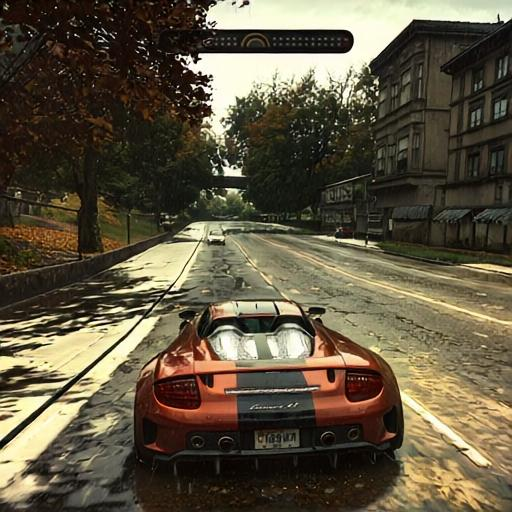

Comparison 2: Left=Original, Right=TensorRT



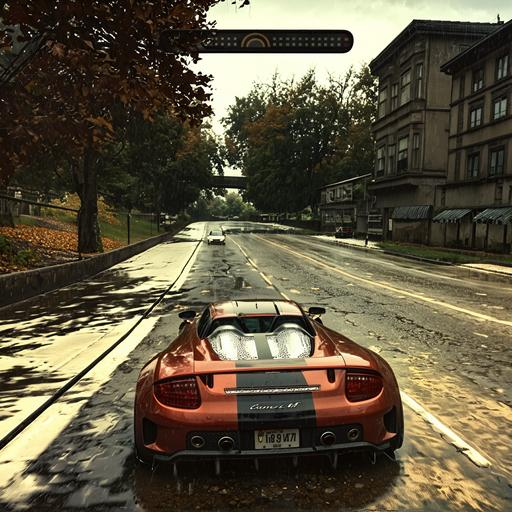
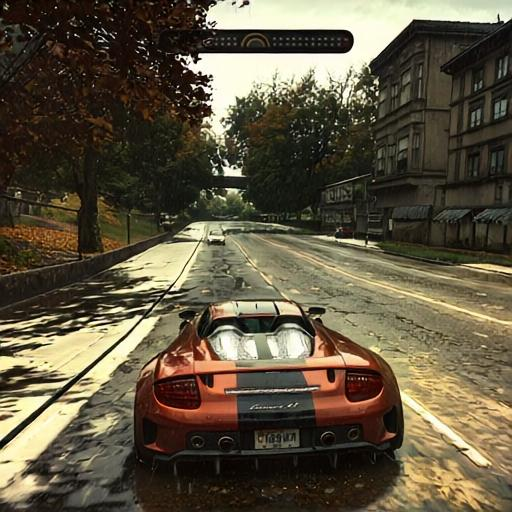

In [6]:
# --- VISUALIZE COMPARE ---
img_orig = tensor_to_image(inp_tensor)
img_torch = tensor_to_image(out_torch)
img_trt = tensor_to_image(out_trt)

print("Comparison 1: Left=Torch, Right=TensorRT")
display(compare(img_torch, img_trt, start_mode="horizontal", start_slider_pos=0.5))

print("Comparison 2: Left=Original, Right=TensorRT")
display(compare(img_orig, img_trt, start_mode="horizontal", start_slider_pos=0.5))